In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/玻璃期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet[sheet['Date'] >= '2023-01-01']
sheet = sheet.set_index('Date')
last_day = sheet['玻璃期货价格拟合残差/玻璃企业库存'].last_valid_index()
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,玻璃期货价格拟合残差/玻璃企业库存,玻璃企业库存(日熔调整/表需季节性预测),玻璃期货价格
2025-12-01,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN
2025-12-05,NaN,311.3329,NaN


In [5]:
file_path1  = 'eta/玻璃期货价格拟合残差-玻璃企业库存_合并数据.xlsx'
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,预测值
19,2025-11-10,-296.2
18,2025-11-11,-247.2
17,2025-11-12,-258.8
16,2025-11-13,-271.1
15,2025-11-14,-251.6


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['玻璃期货价格拟合残差/玻璃企业库存'] = sheet_daily['玻璃期货价格拟合残差/玻璃企业库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:
sheet['玻璃企业库存(日熔调整/表需季节性预测)'] = sheet['玻璃企业库存(日熔调整/表需季节性预测)'].interpolate(method='linear')
sheet.tail()

,玻璃期货价格拟合残差/玻璃企业库存,玻璃企业库存(日熔调整/表需季节性预测),玻璃期货价格
Date,,,
2025-12-01,-241.2,313.88866,NaN
2025-12-02,-195.7,313.24972,NaN
2025-12-03,-183.8,312.61078,NaN
2025-12-04,-183.0,311.97184,NaN
2025-12-05,-200.4,311.33290,NaN


In [8]:
sheet.columns

Index(['玻璃期货价格拟合残差/玻璃企业库存', '玻璃企业库存(日熔调整/表需季节性预测)', '玻璃期货价格'], dtype='object')

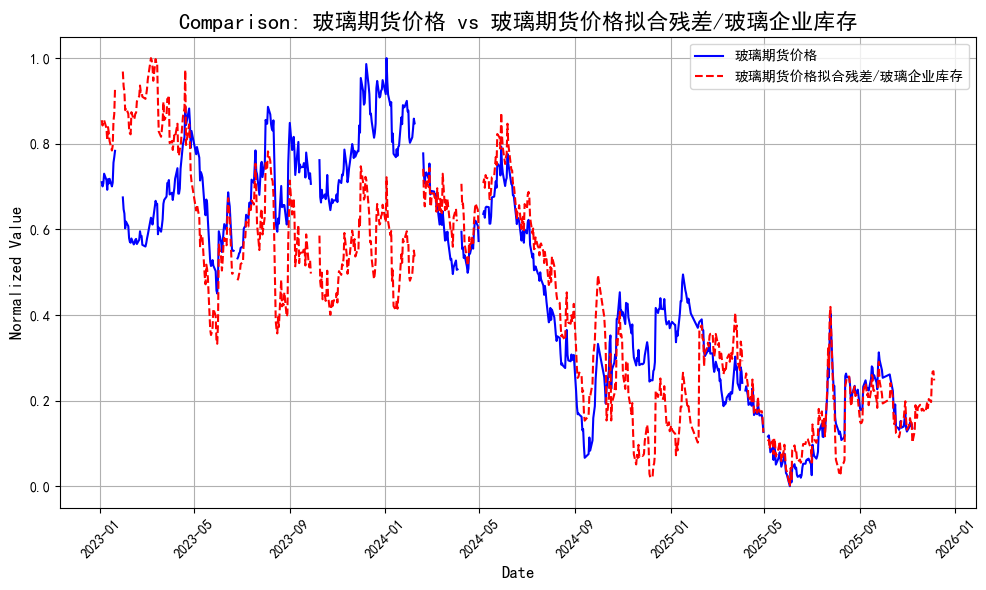

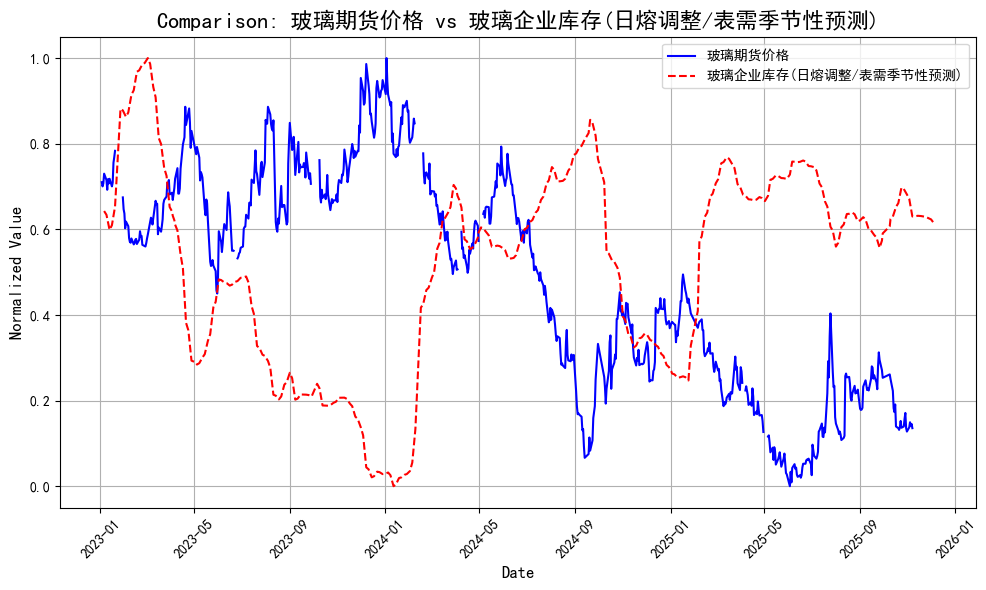

In [9]:
sheet_daily_plot = sheet.copy()
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='玻璃期货价格', 
    compare_cols=['玻璃期货价格拟合残差/玻璃企业库存','玻璃企业库存(日熔调整/表需季节性预测)']
)

In [10]:
sheet_daily = sheet.copy()
sheet_daily = sheet_daily.reset_index()
sheet_daily

,Date,玻璃期货价格拟合残差/玻璃企业库存,玻璃企业库存(日熔调整/表需季节性预测),玻璃期货价格
0,2023-01-03,291.3652,NaN,1672.0
1,2023-01-04,281.3652,NaN,1662.0
2,2023-01-05,288.3652,NaN,1669.0
3,2023-01-06,291.3262,318.94500,1692.0
4,2023-01-09,276.3262,316.67400,1677.0
...,...,...,...,...
714,2025-12-01,-241.2000,313.88866,NaN
715,2025-12-02,-195.7000,313.24972,NaN
716,2025-12-03,-183.8000,312.61078,NaN
717,2025-12-04,-183.0000,311.97184,NaN


In [11]:
# 添加新列 PX-WTI价差_预测
#sheet_daily['玻璃期货价格_预测'] = -2.3998* sheet_daily['玻璃企业库存(日熔调整/表需季节性预测)'] + 2166.1033 + sheet_daily['玻璃期货价格拟合残差/玻璃企业库存'] 
sheet_daily['玻璃期货价格_预测'] = -2.3998* sheet_daily['玻璃企业库存(日熔调整/表需季节性预测)'] + 2066.1033 + sheet_daily['玻璃期货价格拟合残差/玻璃企业库存'] 
sheet_daily.tail()

,Date,玻璃期货价格拟合残差/玻璃企业库存,玻璃企业库存(日熔调整/表需季节性预测),玻璃期货价格,玻璃期货价格_预测
714,2025-12-01,-241.2,313.88866,NaN,1071.633294
715,2025-12-02,-195.7,313.24972,NaN,1118.666622
716,2025-12-03,-183.8,312.61078,NaN,1132.099950
717,2025-12-04,-183.0,311.97184,NaN,1134.433278
718,2025-12-05,-200.4,311.33290,NaN,1118.566607


In [12]:
last_day = sheet_daily['Date'][sheet_daily['玻璃期货价格'].last_valid_index()]


# 创建每日数据框
merged_df_daily = pd.DataFrame()
merged_df_daily['Date'] = sheet_daily['Date']
merged_df_daily['真实值'] = sheet_daily['玻璃期货价格']
merged_df_daily['预测值'] = None

# 在last_day之后填充预测值
mask = merged_df_daily['Date'] > last_day
merged_df_daily.loc[mask, '预测值'] = sheet_daily.loc[mask, '玻璃期货价格_预测']

# 创建月度数据框 
merged_df_montly = pd.DataFrame()
merged_df_montly['Date'] = sheet_daily['Date']
merged_df_montly['真实值'] = sheet_daily['玻璃期货价格']
merged_df_montly['预测值'] = None

# 在2024-01-01之后填充预测值
mask = merged_df_montly['Date'] > '2024-01-01'
merged_df_montly.loc[mask, '预测值'] = sheet_daily.loc[mask, '玻璃期货价格_预测']


In [13]:
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily = merged_df_daily.dropna(subset=['真实值', '预测值'], how='all')
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/玻璃期货价格_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily

,Date,真实值,预测值
718,2025/12/05,NaN,1118.566607
717,2025/12/04,NaN,1134.433278
716,2025/12/03,NaN,1132.09995
715,2025/12/02,NaN,1118.666622
714,2025/12/01,NaN,1071.633294
...,...,...,...
4,2023/01/09,1677.0,None
3,2023/01/06,1692.0,None
2,2023/01/05,1669.0,None
1,2023/01/04,1662.0,None


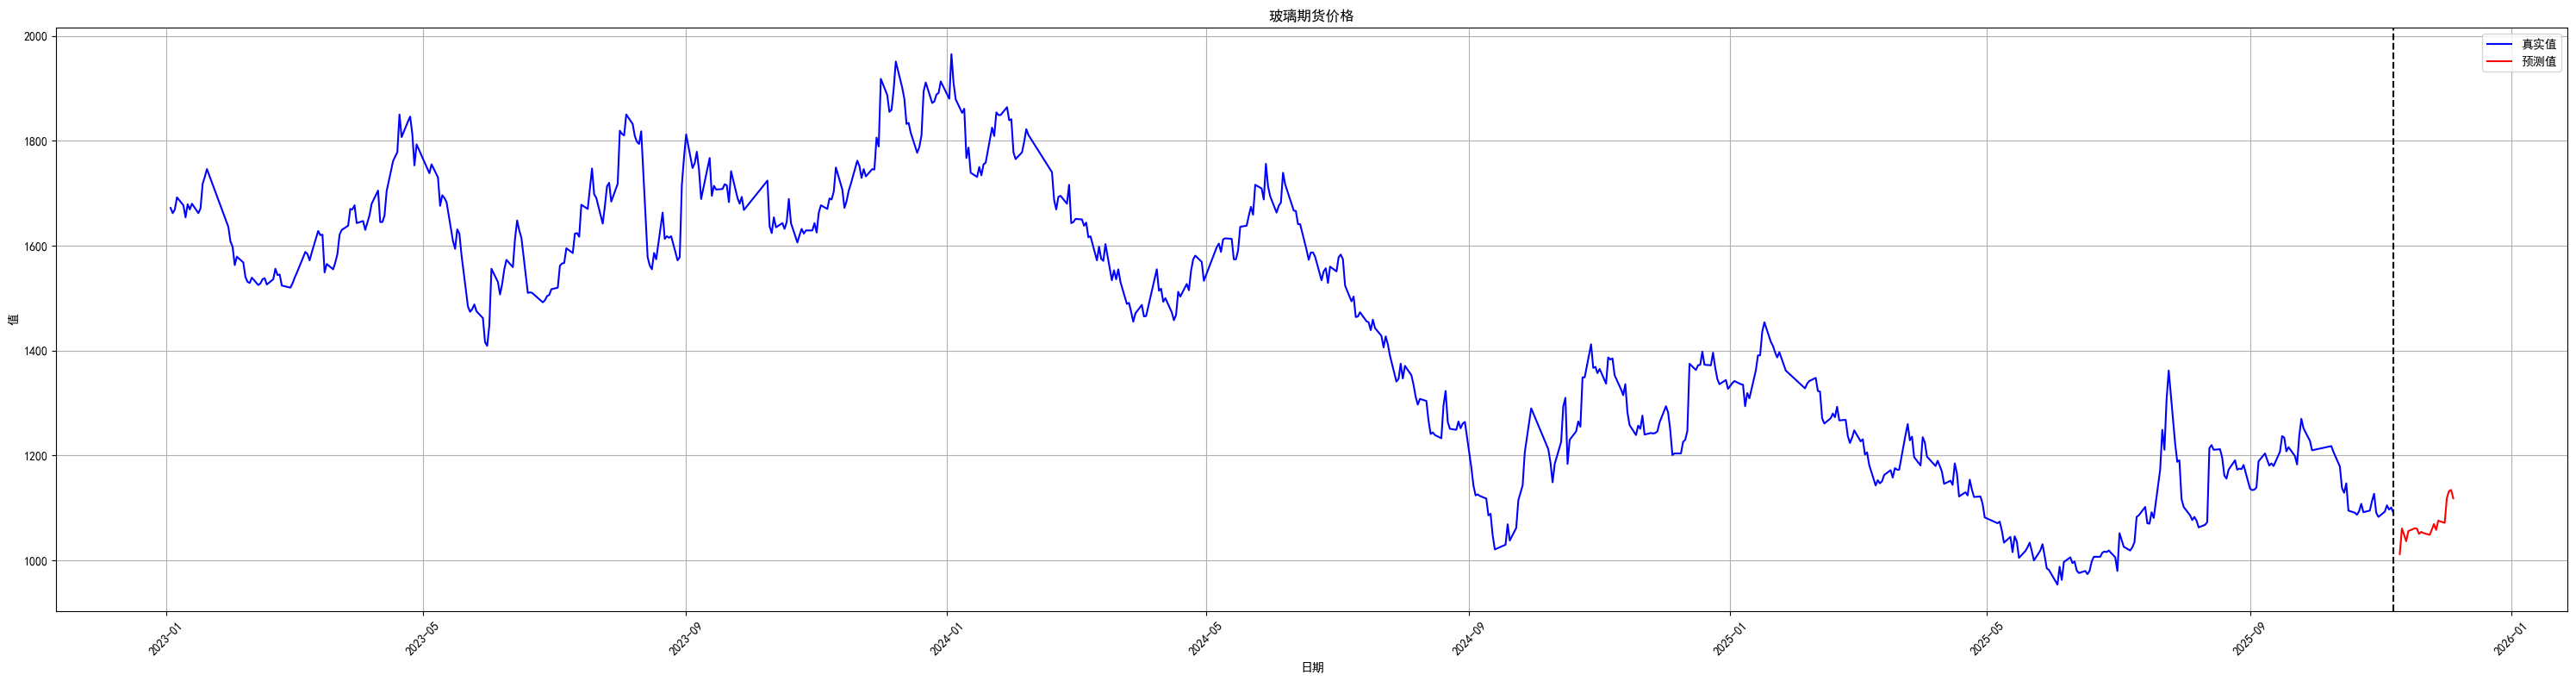

In [14]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['预测值'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

plt.legend()
plt.title('玻璃期货价格')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
merged_df_montly.set_index('Date', inplace=True)
merged_df_montly = merged_df_montly.dropna(subset=['真实值', '预测值'], how='all')
merged_df_monthly = merged_df_montly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/玻璃期货价格_月度数据.xlsx', index=False,float_format= '%.0f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,1115.07995
34,2025/11/30,1097.400000,1042.834601
33,2025/10/31,1123.176471,1017.178661
32,2025/09/30,1198.045455,1100.15346
31,2025/08/31,1146.047619,1042.567395


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "玻璃期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "详情页"
identifier = "玻璃期货价格"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
